In [2]:
import yaml

with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

for key in config["rnn"]["simulation"]:
    exec("{} = {}".format(key, config["rnn"]["simulation"][key]))

for key in config["rnn"]["simulation"]:
    exec("{} = {}".format(key, config["rnn"]["simulation"][key]))
    
for key in config["rnn"]["simulation"]:
    exec("{} = {}".format(key, config["rnn"]["simulation"][key]))

N = config["rnn"]["simulation"]["N"]
timesteps = config["rnn"]["simulation"]["timesteps"]
dt = config["rnn"]["simulation"]["dt"]
alpha = config["rnn"]["simulation"]["alpha"]
beta = config["rnn"]["simulation"]["beta"]

seed = config["rnn"]["model"]["seed"]
train_size = config["rnn"]["model"]["train_size"]
val_size = config["rnn"]["model"]["val_size"]
test_size = config["rnn"]["model"]["test_size"]

loss = config["rnn"]["training"]["loss"]
save = config["rnn"]["data"]["save"]
load = config["rnn"]["data"]["load"]

optimization_steps = config["gridsearch"]["optimization_steps"]
hyperparameters = config["gridsearch"]["hyperparameters"]

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from functions import MachineLearning as ML
from functions import Simulation as SIM
import os
from hyperopt import fmin, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import json

# Set random seed
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
space = {
    'window_size': hp.choice('window_size', [3, 4, 5, 6, 7, 8]),
    'dropout': hp.uniform('dropout', 0.0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'epochs': hp.choice('epochs', [50, 75, 100]),
    'batch_size': hp.choice('batch_size', [10, 20, 25, 30, 35, 40]),
    'hidden_units_per_layer': hp.choice('hidden_units_per_layer', [5, 6, 7, 8, 9])
}

In [5]:
# Specify the folder path
folder_path = r"D:/School/Magistrska/data"

q_i = np.sin(np.linspace(0, np.pi*2, N))
p_i = np.zeros(N)

sim = SIM(q_i, p_i, N, timesteps, dt)

# Check if the folder is empty
if len(os.listdir(folder_path)) == 0:
    print("No saved data, running simulation.")

    qs, ps = sim.integrate(alpha, beta)
    
else:
    print("Found some saved data, skipping simulation.")
    
    qs = np.load(folder_path+"\data_qs_1.npy")
    ps = np.load(folder_path+"\data_ps_1.npy")
    
qs = qs[:, 1:-1]
ps = ps[:, 1:-1]

Found some saved data, skipping simulation.


In [6]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self._init_hidden(batch_size)
        gru_output, _ = self.gru(input, hidden)
        gru_output = self.drop(gru_output)
        output = self.fc(gru_output[:, -1, :])

        return output

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_size)
        return hidden

In [7]:
best_loss = float('inf')

def save_best_model(params, model, loss):
    global best_loss
    if loss < best_loss:
        # Update the best loss
        best_loss = loss
        # Update the best loss
        best_params = params
        # Save the model
        torch.save(model,'D:/School/Magistrska/hyperopt_pytorch/hyperopt_1.pth')
        with open("D:/School/Magistrska/hyperopt_pytorch/best_params.json", 'w') as config_file:
            json.dump(best_params, config_file)

In [8]:
def objective(params):    
    ml = ML(qs, ps, params["window_size"], train_size, val_size, test_size)
    X, y = ml.make_sequences()
    X_train, X_test, X_val, y_train, y_test, y_val = ml.make_split()
    
    # Convert data to PyTorch tensors
    X_train = torch.Tensor(np.array(X_train))
    X_test = torch.Tensor(np.array(X_test))
    X_val = torch.Tensor(np.array(X_val))
    y_train = torch.Tensor(np.array(y_train))
    y_test = torch.Tensor(np.array(y_test))
    y_val = torch.Tensor(np.array(y_val))
    
    # Create PyTorch datasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)
    
    # Create an instance of the model
    model = GRUModel(input_size=N-2, hidden_size=params['hidden_units_per_layer'], output_size=N-2, dropout=params['dropout'])

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Training loop
    ML.gradient_descent(model, params["epochs"], train_loader, optimizer, device, val_loader, train_dataset, val_dataset, criterion, verbose=0)

    # Perform test predictions
    model.eval()
    test_pred = np.copy(X_test[0])

    with torch.no_grad():
        for k in range(len(X_test)):
            inputs = torch.Tensor(test_pred[np.newaxis, -params["window_size"]:]).to(device)
            pred = model(inputs).cpu().numpy()

            test_pred = np.concatenate((test_pred, pred), axis=0)

    test_pred = test_pred[params["window_size"]:]
    y_test = np.array(y_test)
    
    mse = np.sum(np.square(ML.postprocess(y_test) - ML.postprocess(test_pred)), axis=0) / len(y_test)
    mse = np.average(mse)

    # Call the save_best_model callback
    save_best_model(params, model, mse)
    
    return {'loss': mse, 'status': STATUS_OK}

In [8]:
from hyperopt import tpe, atpe, anneal

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

print('Best hyperparameters:', best)

 85%|████████▌ | 17/20 [3:48:47<35:00, 700.01s/trial, best loss: 0.9954282641410828]   

In [9]:
# Open the JSON file and load its contents
with open("D:/School/Magistrska/hyperopt_pytorch/best_params.json", "r") as json_file:
    best_params = json.load(json_file)

model = torch.load('D:/School/Magistrska/hyperopt_pytorch/hyperopt_1.pth')

ml2 = ML(qs, ps, best_params["window_size"], train_size, val_size, test_size)
X, y = ml2.make_sequences()
X_train, X_test, X_val, y_train, y_test, y_val = ml2.make_split()

In [10]:
# Perform test predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
test_pred = np.copy(X_test[0])

with torch.no_grad():
    for k in range(len(X_test)):
        inputs = torch.Tensor(test_pred[np.newaxis, -best_params["window_size"]:]).to(device)
        pred = model(inputs).cpu().numpy()

        test_pred = np.concatenate((test_pred, pred), axis=0)

In [11]:
mse = np.sum(np.square(ML.postprocess(np.array(y_test)) - ML.postprocess(test_pred[best_params["window_size"]:])), axis=0) / len(y_test)
mse = np.average(mse)
print("MSE =", mse)

MSE = 0.9954280248960248


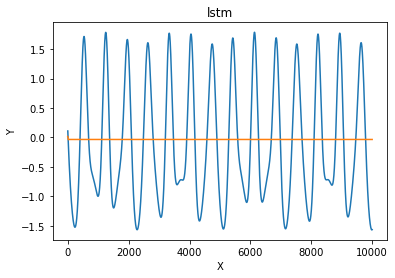

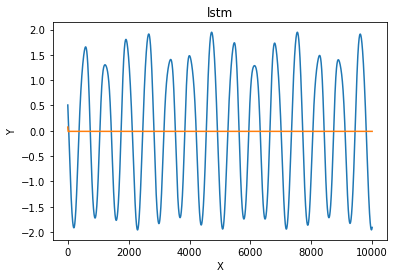

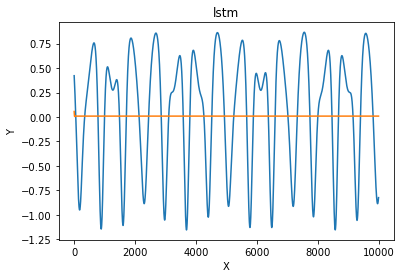

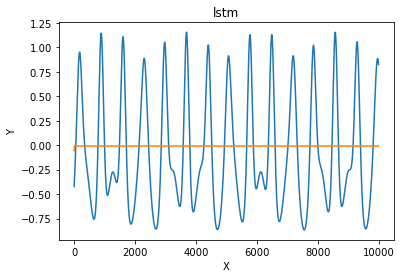

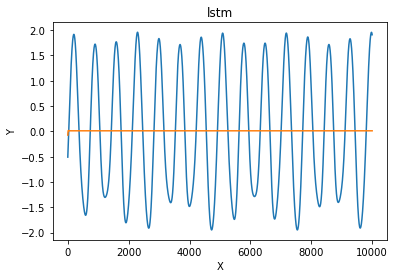

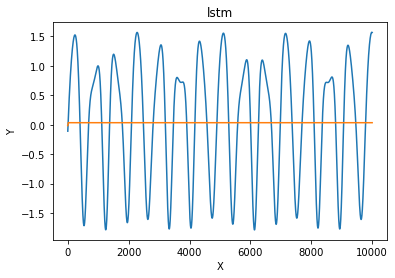

In [12]:
for particles in range(N-2):
    plt.plot(ML.postprocess(np.array(y_test))[:, particles], color="tab:blue")
    plt.plot(ML.postprocess(test_pred[best_params["window_size"]:])[:, particles], color="tab:orange")

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("lstm")
    # plt.ylim(-1.2, 1.2)

    # Show the plot
    plt.show()